## **📊 COVID-19 Radiography Dataset Preprocessing and Model Training**

This script processes the **COVID-19 Radiography Dataset**, performs stratified dataset splitting, trains a ResNet-50 model for classification, evaluates its performance, and visualizes results. The dataset is assumed to be structured with subfolders for each class (e.g., `COVID`, `Normal`, `Viral Pneumonia`, `Lung_Opacity`). The script includes preprocessing, data augmentation, model training, evaluation, and result visualization in a dark theme.

## 📋 Table of Contents
1. [Setup and Imports](#setup-and-imports)
2. [Device Configuration](#device-configuration)
3. [Dataset Loading and Preprocessing](#dataset-loading-and-preprocessing)
4. [Stratified Dataset Splitting](#stratified-dataset-splitting)
5. [DataLoaders Creation](#dataloaders-creation)
6. [Class Distribution Visualization](#class-distribution-visualization)
7. [Model Setup and Training](#model-setup-and-training)
8. [Model Evaluation](#model-evaluation)
9. [Confusion Matrix and Classification Report](#appearance)
10. [Model Saving](#model-saving)

## 🛠️ **Setup and Imports**

- ⚙️ **Device Configuration**

Sets up the computation device (GPU if available, else CPU) and ensures reproducibility with a random seed.

```python
# Configure device (use GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
```

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import pandas as pd

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Configure device (use GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

🔥 Using device: cuda


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

## **📂 Dataset Loading and Preprocessing**
- Loads the dataset from a structured directory and applies preprocessing transforms suitable for ResNet-50.

In [7]:
# Define dataset directory
DATASET_DIR = os.path.join("data", "COVID_Dataset")

In [8]:
# List classes (subfolders in dataset directory)
CLASSES = []
for item in os.listdir(DATASET_DIR):
    item_path = os.path.join(DATASET_DIR, item)
    if os.path.isdir(item_path):
        print(f"📁 Found class: {item}")
        CLASSES.append(item)

📁 Found class: Lung_Opacity
📁 Found class: Viral Pneumonia
📁 Found class: COVID
📁 Found class: Normal


## **Visualize one sample image per class**

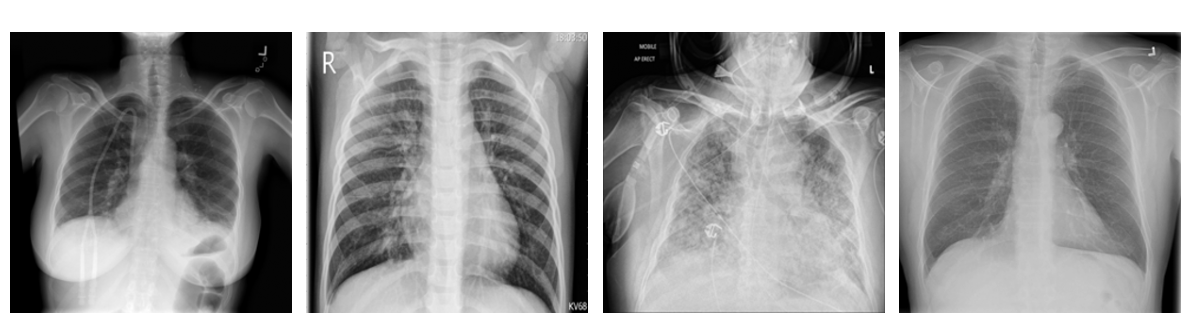

In [9]:
plt.figure(figsize=(12, 8))
for i, cls in enumerate(CLASSES):
    # Get the first image in the class directory
    img_path = os.path.join(DATASET_DIR, cls, os.listdir(os.path.join(DATASET_DIR, cls))[0])
    img = Image.open(img_path)
    plt.subplot(1, len(CLASSES), i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls, color="white")
    plt.axis("off")
plt.tight_layout()
plt.show()

## **Define preprocessing transforms**

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet-50
    transforms.RandomRotation(10),  # Random rotation (±10 degrees) for augmentation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.ToTensor(),  # Convert to tensor (HWC to CHW, [0, 255] to [0, 1])
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet mean
        std=[0.229, 0.224, 0.225]    # Normalize with ImageNet std
    )
])

## **Load dataset with transforms**

In [11]:
try:
    dataset = ImageFolder(root=DATASET_DIR, transform=transform)
    print("✅ Dataset loaded successfully.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit(1)

✅ Dataset loaded successfully.


## **Print dataset details**

In [12]:
class_names = dataset.classes
num_classes = len(class_names)
print(f"🏷️ Classes: {class_names}")
print(f"🔢 Number of classes: {num_classes}")
print(f"📈 Total samples: {len(dataset)}")

🏷️ Classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
🔢 Number of classes: 4
📈 Total samples: 21165


## **Function to perform stratified split**

In [13]:
def stratified_split(dataset, train_size=0.7, val_size=0.15):
    """
    Splits dataset into train, validation, and test sets with stratified sampling.

    Args:
        dataset: PyTorch dataset object
        train_size (float): Proportion of data for training (default: 0.7)
        val_size (float): Proportion of data for validation (default: 0.15)

    Returns:
        tuple: Indices for train, validation, and test sets
    """
    # Get labels for all samples
    labels = [dataset.targets[i] for i in range(len(dataset))]

    # Split into train and temp (val+test)
    train_idx, temp_idx = train_test_split(
        range(len(dataset)),
        train_size=train_size,
        stratify=labels,
        random_state=42
    )

    # Update labels for temp set
    temp_labels = [labels[i] for i in temp_idx]

    # Split temp into val and test
    val_idx, test_idx = train_test_split(
        temp_idx,
        train_size=val_size / (1 - train_size),  # Proportion of val in temp
        stratify=temp_labels,
        random_state=42
    )

    return train_idx, val_idx, test_idx

In [14]:
# Perform stratified split
train_idx, val_idx, test_idx = stratified_split(dataset, train_size=0.7, val_size=0.15)

In [15]:
# Create subsets
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [16]:
# Verify split sizes
print(f"🚂 Training set size: {len(train_dataset)}")
print(f"🔍 Validation set size: {len(val_dataset)}")
print(f"🧪 Test set size: {len(test_dataset)}")

🚂 Training set size: 14815
🔍 Validation set size: 3174
🧪 Test set size: 3176


In [19]:
# Check if splits sum to total dataset size
assert len(train_dataset) + len(val_dataset) + len(test_dataset) == len(dataset), "❌ Split sizes do not match dataset size"

#### **Notes:**
- Stratified Sampling: Ensures each split has a similar class distribution, critical for imbalanced datasets.
- Split Ratios: 70% training, 15% validation, 15% test. Adjustable via `train_size` and `val_size`.
- Assertion: Verifies that the splits cover the entire dataset.

## **📦 DataLoaders Creation**
- Creates `DataLoader` objects for efficient batch processing during training and evaluation.

In [20]:
# Define batch size
batch_size = 128  # Adjust based on GPU memory

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=4,  # Parallel data loading
    pin_memory=True  # Faster data transfer to GPU
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for testing
    num_workers=4,
    pin_memory=True
)

print("🚀 DataLoaders created successfully.")

🚀 DataLoaders created successfully.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### **Notes:**
- **Batch Size:** Set to 128; reduce if GPU memory is limited (e.g., to 64 or 32).
- **num_workers:** Uses 4 workers for parallel loading; set to 0 on Windows if issues arise.
- **pin_memory:** Speeds up data transfer to GPU.

## **📊 Class Distribution Visualization**
- Visualizes the class distribution across splits in a dark-themed bar plot.

In [21]:
def get_class_distribution(dataset_subset, class_names):
    """
    Computes the number of samples per class in a dataset or subset.

    Args:
        dataset_subset: PyTorch dataset or subset
        class_names (list): List of class names

    Returns:
        dict: Class names mapped to sample counts
    """
    if isinstance(dataset_subset, torch.utils.data.Subset):
        labels = [dataset.targets[i] for i in dataset_subset.indices]
    else:
        labels = dataset.targets
    counts = Counter(labels)
    return {class_names[i]: counts.get(i, 0) for i in range(len(class_names))}

In [22]:
# Get class distributions
train_dist = get_class_distribution(train_dataset, class_names)
val_dist = get_class_distribution(val_dataset, class_names)
test_dist = get_class_distribution(test_dataset, class_names)

# Print distributions
print("\n📊 Class Distribution:")
print(f"Training: {train_dist}")
print(f"Validation: {val_dist}")
print(f"Test: {test_dist}")


📊 Class Distribution:
Training: {'COVID': 2531, 'Lung_Opacity': 4208, 'Normal': 7134, 'Viral Pneumonia': 942}
Validation: {'COVID': 542, 'Lung_Opacity': 902, 'Normal': 1529, 'Viral Pneumonia': 201}
Test: {'COVID': 543, 'Lung_Opacity': 902, 'Normal': 1529, 'Viral Pneumonia': 202}


In [23]:
# Create DataFrame for visualization
dist_df = pd.DataFrame({
    "Class": class_names * 3,
    "Count": list(train_dist.values()) + list(val_dist.values()) + list(test_dist.values()),
    "Split": ["Training"] * num_classes + ["Validation"] * num_classes + ["Test"] * num_classes
})

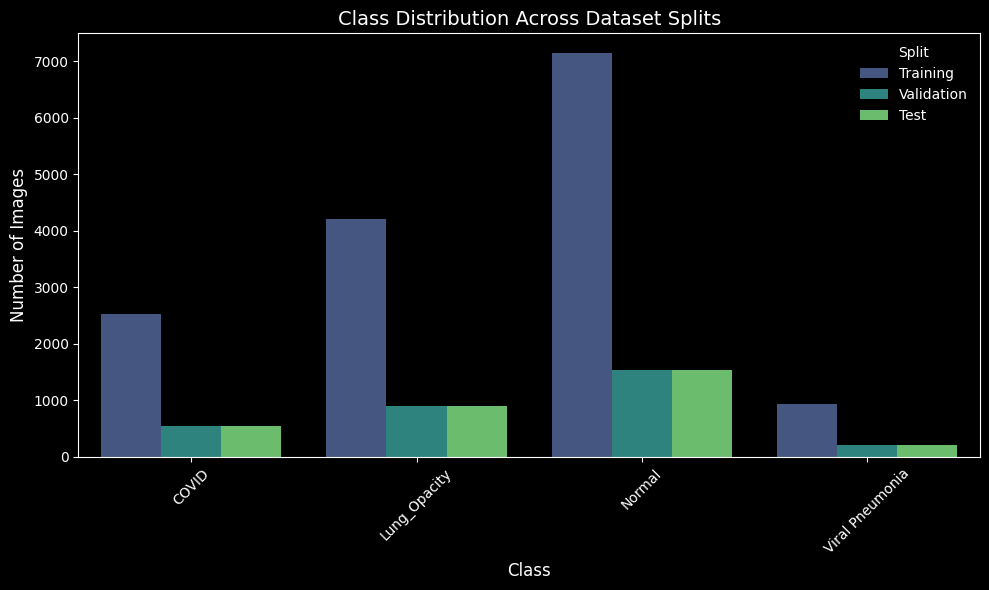

In [34]:
# Plot class distribution
plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=dist_df,
    x="Class",
    y="Count",
    hue="Split",
    palette="viridis"
)
plt.title("Class Distribution Across Dataset Splits", color="white", fontsize=14)
plt.xlabel("Class", color="white", fontsize=12)
plt.ylabel("Number of Images", color="white", fontsize=12)
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.legend(title="Split", loc="upper right", frameon=False, labelcolor="white")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

#### **Notes:**
- Visualization: Shows class counts for each split, helping identify imbalances.
- Dark Theme: Uses dark_background style with viridis palette for professional appearance.

## **🧠 Model Setup and Training**
- Sets up a pre-trained ResNet-50 model, modifies its final layer, and trains it on the dataset.

In [25]:
# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)

# Modify final fully connected layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [26]:
# Training loop
num_epochs = 10
print("\n🚀 Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    # Compute epoch metrics
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")


🚀 Starting training...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Loss: 0.3113, Train Acc: 88.50%
Epoch [2/10], Loss: 0.1601, Train Acc: 94.24%
Epoch [3/10], Loss: 0.1340, Train Acc: 95.34%
Epoch [4/10], Loss: 0.1045, Train Acc: 96.33%
Epoch [5/10], Loss: 0.0911, Train Acc: 96.90%
Epoch [6/10], Loss: 0.0786, Train Acc: 97.17%
Epoch [7/10], Loss: 0.0727, Train Acc: 97.47%
Epoch [8/10], Loss: 0.0599, Train Acc: 97.91%
Epoch [9/10], Loss: 0.0566, Train Acc: 97.91%
Epoch [10/10], Loss: 0.0515, Train Acc: 98.14%


## **🔍 Model Evaluation**
- Evaluates the model on the test set and computes accuracy.

In [27]:
# Function to evaluate model
def evaluate_model(model, dataloader, device):
    """
    Evaluates model on a dataset and collects predictions.

    Args:
        model: PyTorch model
        dataloader: DataLoader for evaluation
        device: Computation device

    Returns:
        tuple: True labels and predicted labels
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"🎯 Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds

In [28]:
# Evaluate model on test set
true_labels, predicted_labels = evaluate_model(model, test_loader, device)

🎯 Test Accuracy: 94.14%


#### **Notes:**
- **Evaluation:** Computes accuracy and collects predictions for further analysis.
- **No Gradients:** Uses `torch.no_grad()` to reduce memory usage during evaluation.

## **📈 Confusion Matrix and Classification Report**
- Visualizes the confusion matrix and prints a classification report.

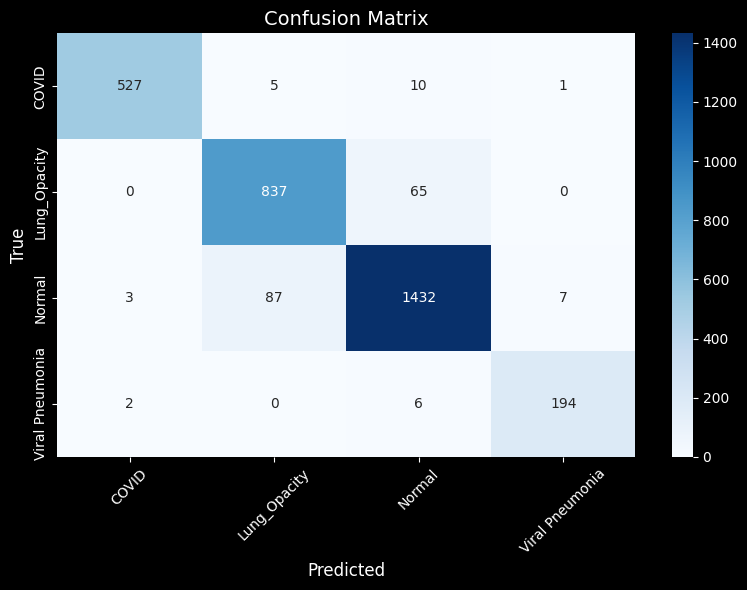


📝 Classification Report:
                 precision    recall  f1-score   support

          COVID       0.99      0.97      0.98       543
   Lung_Opacity       0.90      0.93      0.91       902
         Normal       0.95      0.94      0.94      1529
Viral Pneumonia       0.96      0.96      0.96       202

       accuracy                           0.94      3176
      macro avg       0.95      0.95      0.95      3176
   weighted avg       0.94      0.94      0.94      3176



In [29]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
plt.title("Confusion Matrix", color="white", fontsize=14)
plt.xlabel("Predicted", color="white", fontsize=12)
plt.ylabel("True", color="white", fontsize=12)
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Print classification report
print("\n📝 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))

#### **Notes:**
- Confusion Matrix: Visualizes prediction errors in a dark-themed heatmap.
- Classification Report: Provides precision, recall, and F1-score per class.

## **💾 Model Saving**
- Saves the trained model for future use.

In [30]:
# Save model
os.makedirs("models", exist_ok=True)
save_path = os.path.join("models", "resnet50_covid_classifier.pth")
torch.save(model.state_dict(), save_path)
print(f"💾 Model saved at {save_path}")

💾 Model saved at models/resnet50_covid_classifier.pth
